[arseny-n](https://www.kaggle.com/arsenynerinovsky/cellular-automata-as-a-language-for-reasoning) showed us that Cellular Automata can be used as a language for solving ARC challenges, and provided us with a few example solutions. In this notebook we'll explore how we can use neural networks to create cellular automata. We'll start with Conway's Game of Life, and then move on to see if we can replicate his results using learned cellular automata. (See [part II](https://www.kaggle.com/teddykoker/training-cellular-automata-part-ii-learn-a-task)).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
device = torch.device("cuda:2")

# Introduction: Conway's Game of Life

Before we start training models on the ARC, lets see how we can use neural networks to learn a Cellular Automata that we already know: Conway's Game of Life (GOL). We'll start out by creating our input $x$, 10 different random 32x32 grids, then performing one transition step to get our output, $y$. I chose to keep the train set relitively small to reflect the nature of the ARC challenge.

In [2]:
train_size, width, height = (1000, 32, 32)

def gol(x):
    # performs one step of Conway's Game of Life
    # http://jakevdp.github.io/blog/2013/08/07/conways-game-of-life/
    nbrs_count = sum(np.roll(np.roll(x, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (nbrs_count == 3) | (x & (nbrs_count == 2))


x_train = np.random.randint(0, 2, size=(train_size, width, height))
y_train = np.stack([gol(d) for d in x_train])
x_train = np.stack([1 - x_train, x_train], axis=1) # one channel per color

x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).to(device)

## Model

We'll use a very simple model to recreate the rules of GOL. The first layer pads the edges of the grid by sampling the values from the opposite side. The rest of the layers consists of first a 3x3 convolutional layer, which samples the "neighborhood" around each cell, followed by 2 1x1 convolutional layers, which effectively act as fully connected layers for each neighborhood sample. The output of the model is the same as the input, a channel of values representing dead cells, and a channel of values representing alive cells, this allows the output to be repeatedly fed back into the input, peforming one transition each time. This model is inspired in part by [(Gilpin, 2018)](https://arxiv.org/abs/1809.02942).

In [3]:
class CircularPad(nn.Module):
    def forward(self, x):
        return F.pad(x, (1, 1, 1, 1), mode="circular")
    
gol_model = nn.Sequential(
    CircularPad(),
    nn.Conv2d(2, 8, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(8, 8, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(8, 2, kernel_size=1)
).to(device)

## Training

We'll train the model using Cross Entropy Loss for 1000 epochs. We can see that the model converges nicely.

Last loss: 0.00109


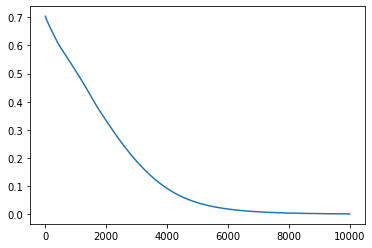

In [4]:
num_epochs = 10000

optimizer = torch.optim.Adam(gol_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

losses = np.zeros(num_epochs)
for e in range(num_epochs):
    optimizer.zero_grad()
    y_pred = gol_model(x_train)
    loss = criterion(y_pred, y_train)
    losses[e] = loss.item()
    loss.backward()
    optimizer.step()

plt.plot(losses)
print(f"Last loss: {losses[-1]:.5f}")

## Test: Glider

An easy way to test our model is to repeatedly pass through a <a href="https://en.wikipedia.org/wiki/Glider_(Conway%27s_Life)">glider</a>. If our model has learned correctly, we should see the glider travel across the grid.

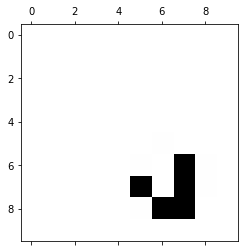

In [5]:
glider = np.array([[0,1,0],
                   [0,0,1],
                   [1,1,1]])
state = np.zeros((10, 10))
state[:3,:3] = glider
state = np.stack([1 - state, state])
state = torch.from_numpy(state).float().unsqueeze(0).to(device)

@torch.no_grad()
def animate(i):
    global state
    state = torch.softmax(gol_model(state), dim=1)
    mat.set_data(state.cpu().numpy()[0,0])

fig, ax = plt.subplots()
mat = ax.matshow(state.cpu().numpy()[0,0], cmap="gray")
anim = animation.FuncAnimation(fig, animate, frames=100, interval=60)
HTML(anim.to_jshtml())

Looks like it works! Now we see if we can apply the same principles to solving some of the ARC challenges. ~~Stay tuned for Part II!~~ [Part II](https://www.kaggle.com/teddykoker/training-cellular-automata-part-ii-learn-a-task).